<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>

---


# **Generative Adversarial Networks (GANs)**

#### **Morning contents/agenda**

1. Why GANs?

2. Recap of generative models and VAEs

3. Formulation and training strategy

4. Implemention of a simple GAN

5. Pros and cons

6. Overview of main GAN flavours

#### **Learning outcomes**

1. Understand the basic principles of adversarial traning (with two competing networks)

2. Implementa a Generator and a Discriminator and train them with a simple GAN

3. Be aware of the importance of GANs in deep learning, its many variations, benefits, and limitations

<br>

#### **Afternoon contents/agenda**

1. Conditional GANs

2. Wasserstein GANs theory and implementation example. Materials provided for Wasserstein GAN (for information only, **you will NOT be assessed on WGANs**)

#### **Learning outcomes**

1. Understand how Conditional GANs can be used to generate samples of a specific class

<br/>

---


In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random

In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Conditional Generative Adversarial Networks (cGANs)

Conditional GANs (cGANs) are a variation of conventional GANs that enable the generation of realistic data that match specific labels. This variation greatly improves the value of GANs in real practice.

In our MNIST case, we can adapt the GAN architecture from the morning lecture to generate number-specific images (e.g., 1000 images of the number 5), instead of generating random digits every time.

cGANs were introduced in [this](https://arxiv.org/abs/1411.1784) paper. In this exercise, we will implement this architure to include labels of MNIST in our generator. The architecture of cGANs is shown below:

![](https://miro.medium.com/max/700/1*Vjo1df-yPFks2e_-TbdWdQ.png)

Image credit: [medium blog](https://medium.com/@ma.bagheri/a-tutorial-on-conditional-generative-adversarial-nets-keras-implementation-694dcafa6282)




## 1. Train a conditional GAN

The first question we need to ask ourselves in order to implemente a cGAN is: **how to put label into the network?**

There are different ways we could do this, but the simplest one is just to concatenate the (one-hot encoded) label with the input of the network.

If, for example, we had a latent vector of length 128 and the conditioning vector had size 10 (for the 10 classes in MNIST, with the value of 1 at the index of the class and 0 elsewhere), the input of the generator network will be of size 128 + 10 = 138.

Similarly, if the input to our GAN discriminator is of size 784 (28 x 28 images in MNIST), the input to our cGAN discriminator will be 784 + 10 = 794.



### **1.1. Create the conditional generator**

Let's start by building our conditional generator. For this, we will use the following hyperparameters:

- Latent vector length: 128
- Length of the conditioning vector: 10

The network itself will be composed of the following layers:

0. Concatenate `z` and `label` using torch.cat()
1. Layer 1 for the latent vector: 128 + 10 -> 256
2. Layer 2 for the label vector: 256 -> 512
3. Layer 2: 512 -> 1024
4. Layer 4: 1024 -> 784 (size of a MNIST image)

We will appply the ``LeakyReLU(0.2)`` activation functions for layers 1-3, and ``tanh`` to the final layer.

**Consider:** Why do we use the `tanh` as the final layer's activation?

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim + num_classes, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.activation = nn.LeakyReLU(0.2)

    # forward method
    def forward(self, z, label):
        z = torch.cat([z, label], 1)
        x = self.activation(self.fc1(z))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return torch.tanh(self.fc4(x)) # Our input is in the range [-1, 1]

As always, let's test that the model is doing what we think it's doing:

In [6]:
# Build model
z_dim = 128
x_dim = 28*28
num_classes = 10

G = Generator(z_dim, x_dim, num_classes).to(device)

# Test output
G(torch.randn(10, z_dim).to(device), torch.randn(10, num_classes).to(device)).shape

torch.Size([10, 784])

### **1.2. Create the conditional discriminator**

Next, we can build the conditional discriminator network. In this case, the network will have the following layers:

0. Concatenate `x` and `label` here using torch.cat()
1. Layer 1: 794 -> 1024
2. Layer 2: 1024 -> 512
3. Layer 3: 512 -> 256
4. Layer 4: 256 -> 1


We will apply ``LeakyReLU(0.2)`` activation functions for layers 1-3, and ``Sigmoid`` to the final layer.

**Consider:** Why do we use the `Sigmoid` as the final layer's activation?

In [7]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(d_input_dim + num_classes, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3) # We regularise the discriminator by adding dropout so it doesn't memorise
                                       # the training data

    # forward method
    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x)) # Our discriminator is a binary classifier with probability between [0, 1]

Which we can now test:

In [8]:
# Build model
z_dim = 128
x_dim = 28*28
num_classes = 10

D = Discriminator(x_dim, num_classes).to(device)

# Test output
D(torch.randn(10, x_dim).to(device), torch.randn(10, num_classes).to(device)).shape

torch.Size([10, 1])

### **1.3. Create the dataloader, optimisers and criterion**

Now that we have created a model, we can prepare our dataset. We will use a batch size of 64 and normalise the MNIST dataset to the range [-1,1].



In [9]:
# MNIST Dataset
batch_size=64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 524kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]


We will also create our optimiser. In this case, we will use ``Adam`` with ``learning_rate = 2e-4``.

In [10]:
# Optimisers
lr = 0.0002
G_optimiser = torch.optim.Adam(G.parameters(), lr = lr)
D_optimiser = torch.optim.Adam(D.parameters(), lr = lr)

And, finally, we will use BCE as the criterion:

In [11]:
# Loss function
criterion = nn.BCELoss()

### **1.3. Adapt the ``D_train`` and ``G_train`` functions**

To finalise our setup, we will need to adapt the `D_train` and `G_train` functions we built this morning to include the conditioning.

**Consider**: Think about how you need to format the class labels from the data loader to the class vectors ``(batch_size, num_classes)`` required for conditioning.

Let's start with `D_train`:

In [12]:
def D_train(x, cond):                  ## take in the labels
    #-------------- Function of the discriminator training -------------------#
    D.train()
    D_optimiser.zero_grad()

    bs = x.shape[0]

    # Create conditioning vector for real data of size (bs, num_classes)
    c = torch.zeros(bs, num_classes)   ## create an empty tensor that will contain the one-hot encoded conditioning
    c.scatter_(1, cond.view(bs, 1), 1) ## use scatter to fill the tensor using the class labels
    c = c.to(device)                   ## send the tensor to the device

    # Real data reshaped -- label for all real samples is 1
    x_real, y_real = x.view(-1, 28*28), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    # Training loss for real data
    D_output = D(x_real, c)           ## ensure the conditioning is passed to the network
    D_real_loss = criterion(D_output, y_real)

    # Create conditioning vector for fake data of size (bs, num_classes)
    c = torch.zeros(bs, num_classes)  ## create an empty tensor that will contain the one-hot encoded conditioning
    c.scatter_(1, torch.randint(low=0, high=10, size=(bs, 1)), 1) ## fill in the tensor using random class labels
    c = c.to(device)                  ## send the tensor to the device

    # Sample vector and generation of fake data -- label for all fake samples is 0
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z, c), torch.zeros(bs, 1).to(device)   ## ensure the conditioning is passed to the network

    # Training loss for fake fata
    D_output = D(x_fake.detach(), c)  ## ensure the conditioning is passed to the network
    D_fake_loss = criterion(D_output, y_fake)

    # Combine the losses
    D_loss = D_real_loss + D_fake_loss

    # Backpropagate and model update
    D_loss.backward()
    D_optimiser.step()


    return  D_loss.data.item()


Next, we apply the changes to `G_train`:

In [13]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimiser.zero_grad()

    bs = x.shape[0]

    # Create conditioning vector for fake data of size (bs, num_classes)
    c = torch.zeros(bs, num_classes)  ## create an empty tensor that will contain the one-hot encoded conditioning
    c.scatter_(1, torch.randint(low=0, high=10, size=(bs, 1)), 1) ## fill in the tensor using random class labels
    c = c.to(device)                  ## send the tensor to the device

    # Sample vector and generation of fake data
    z = torch.randn(bs, z_dim).to(device)
    x_fake = G(z, c)                  ## ensure the conditioning is passed to the network

    # To "fool" the discriminator, fake data labels are set to 1
    y = torch.ones(bs, 1).to(device)

    # Training loss of the generator
    D_output = D(x_fake, c)           ## ensure the conditioning is passed to the network
    G_loss = criterion(D_output, y)

    # Backpropagate and model update
    G_loss.backward()
    G_optimiser.step()

    return G_loss.data.item()


### **1.4. Train the network**

We are now ready to train our model. We will need to make a small change to the training loop from this morning to include the labels.

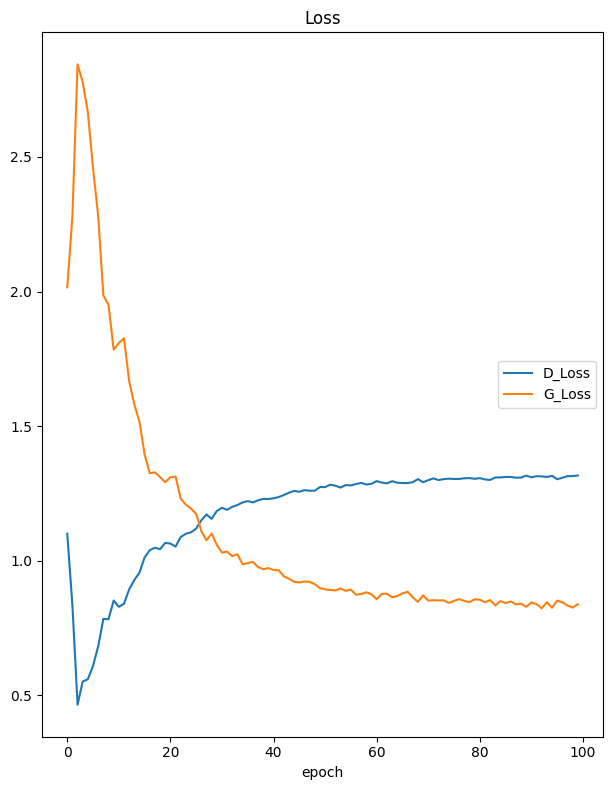

Loss
	D_Loss           	 (min:    0.465, max:    1.316, cur:    1.316)
	G_Loss           	 (min:    0.823, max:    2.844, cur:    0.838)


In [14]:
n_epoch = 100
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
    d_loss_epoch, g_loss_epoch = 0, 0
    logs = {}
    for batch_idx, (x, labels) in enumerate(train_loader):
        d_loss_epoch += D_train(x, labels)  ## pass in the labels
        g_loss_epoch += G_train(x)
    logs['D_Loss'] = d_loss_epoch / len(train_loader)
    logs['G_Loss'] = g_loss_epoch / len(train_loader)
    liveloss.update(logs)
    liveloss.draw()


    # save every 20th epochs
    if(np.mod(epoch, 20) == 0):
        torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

**Consider:**

1. Does the training behave as expected?
2. How do would you know if the training has completed successfully or not?

### **1.5. Use the trained generators**

We will now use the trained generator to create 10 images for every class in our MNIST dataset.

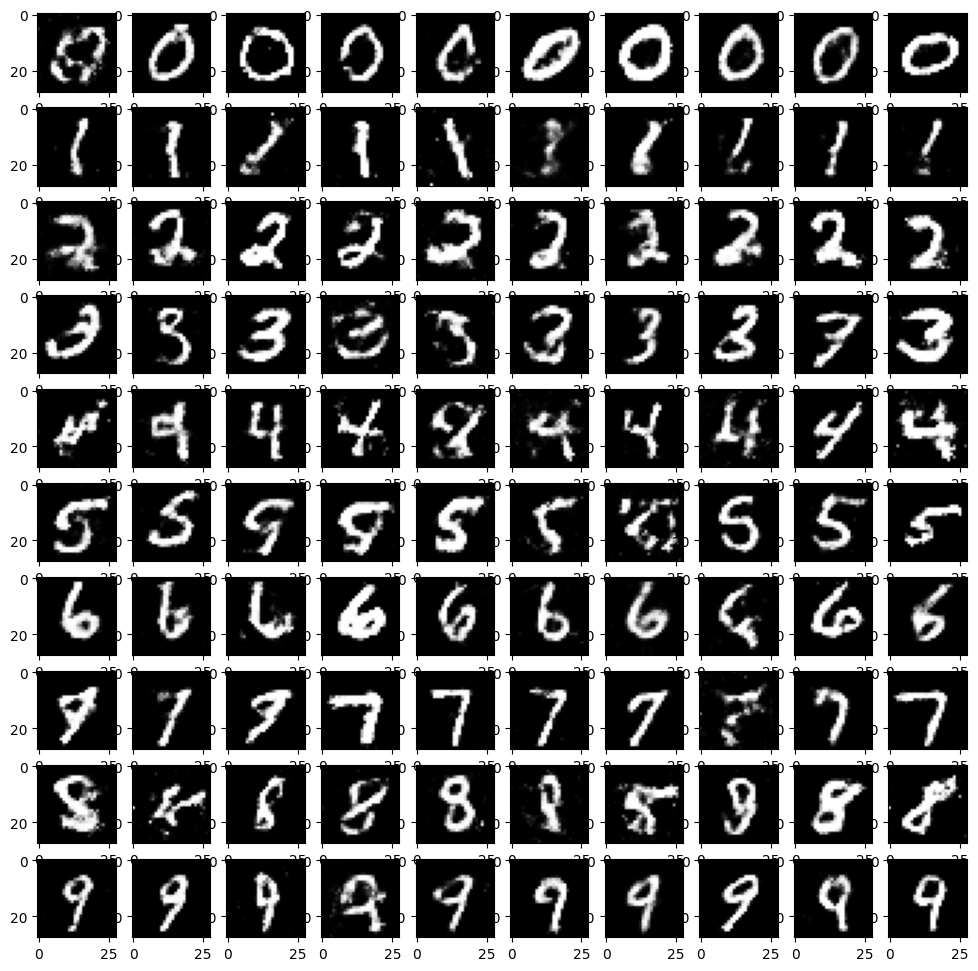

In [15]:
# You can load the trained generator if needed
# epoch = 100
# G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))

with torch.no_grad():
    # Random vector
    z = torch.randn(100, z_dim).to(device)

    # Conditioning from 0 to 10
    z_label = torch.zeros(100, 10)
    z_labels = torch.LongTensor([i for i in range(10) for _ in range(10)])
    z_label.scatter_(1, z_labels.view(100, 1), 1)

    # Generate images
    generated = G(z, z_label.to(device))

# Plot
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.show()

<br>

---

<br>